GravLensing Project code compilation

In [1]:
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset


from torchvision import datasets, transforms
import torchvision
import torchinfo

torch.manual_seed(42)

new Dataset class:

In [2]:
class DatasetFolder:
    def __init__(self, root_dir, transforms):
        self.root_dir=root_dir
        self.transforms=transforms
    def __len__(self):
        return len(os.listdir(self.root_dir))
    def __getitem__(self,index):
        label=os.listdir(self.root_dir)[index]
        fits_path=r''+self.root_dir+'/'+label
        file=fits.getdata(fits_path, ext=0)
        file=file.astype(float)
        file=np.transpose(file, (1,0,2))
        if self.transforms:
            file=self.transforms(file)
        if label[:4]=='lens':
            newlabel=np.float32(1.0)
        else: newlabel=np.float32(0.0)
        
        return (file, newlabel)

Initialisation of data:

['lens_1', 'lens_2', 'lens_3', 'lens_4', 'lens_5']
['nonlens_1', 'nonlens_2', 'nonlens_3', 'nonlens_4', 'nonlens_5']
train dataset: 52200
test dataset: 17400
validation dataset: 17400
1632
544
544


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 640x480 with 0 Axes>

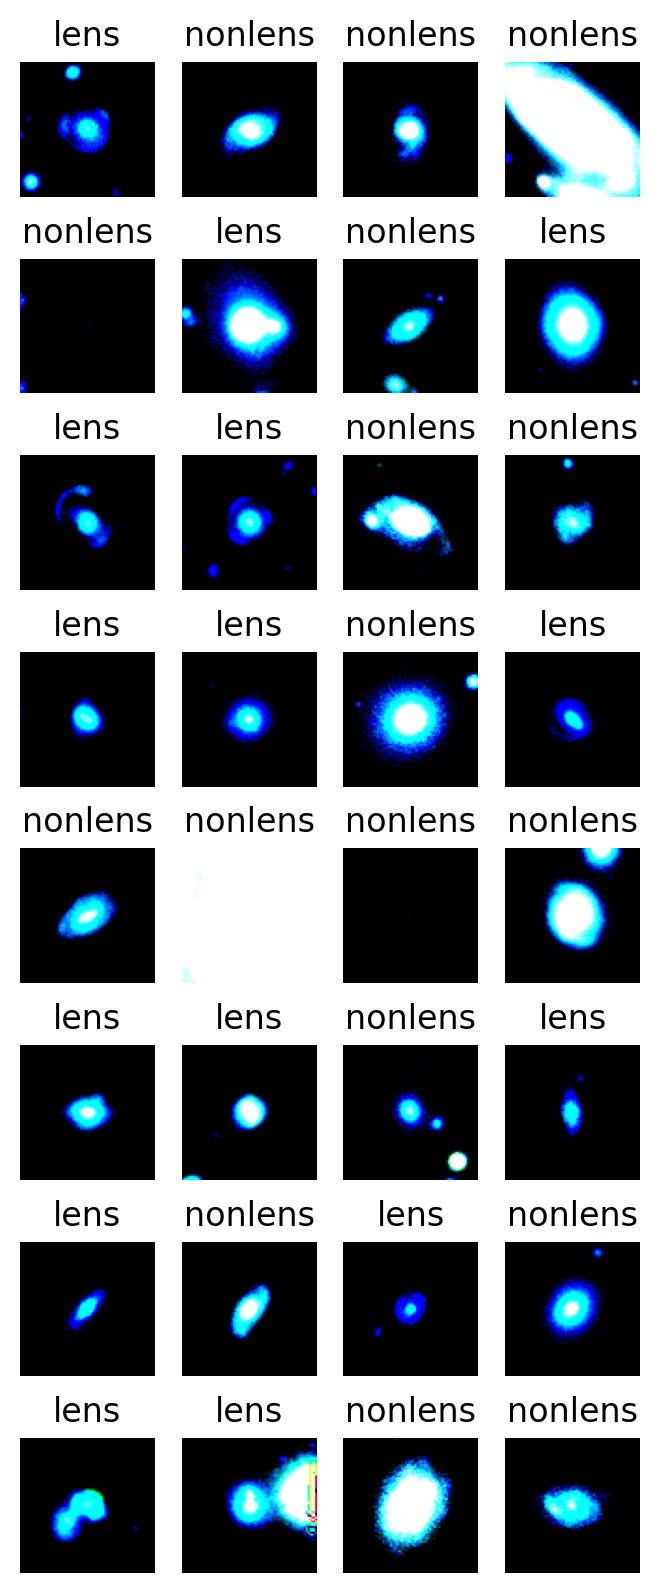

In [3]:

#creating relative path to data for use on different devices
filedir=r'C:/Users/sonya/gravLensing/gravlensing_sonya.francisco/tum_project/lens'
filedirnon=r'C:/Users/sonya/gravLensing/gravlensing_sonya.francisco/tum_project/nonlens'
filename1=os.listdir(filedir)
filename1non=os.listdir(filedirnon)
print(filename1) #gives the filenames lens_1 etc.
print(filename1non)

#lenses contains the subfiles of type Datasetfolder
lenses = []
nonlenses=[]

#transforms used on the images
transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

for filename in filename1:
    filedir2=r''+filedir+'/'+filename
    filename2=os.listdir(filedir2)
    data=DatasetFolder(filedir2, transform)
    lenses.append(data)
for filenamenon in filename1non:
    filedir2non=r''+filedirnon+'/'+filenamenon
    filename2non=os.listdir(filedir2non)
    datanon=DatasetFolder(filedir2non, transform)
    nonlenses.append(datanon)



#concat all the lenses into one dataset
image_dataset = torch.utils.data.ConcatDataset(lenses)
image_dataset_non = torch.utils.data.ConcatDataset(nonlenses)
arr=[image_dataset, image_dataset_non]
total =torch.torch.utils.data.ConcatDataset(arr)

#splitting the images:
train_dataset, test_dataset, validation_dataset = torch.utils.data.random_split(total, [int(0.6*len(total)), int(0.2*len(total)), int(0.2*len(total))])

print('train dataset:', len(train_dataset))
print('test dataset:', len(test_dataset))
print('validation dataset:', len(validation_dataset))
#-> 1: image, 2: pixel number, 3: which of the 3 channels

#DataLoaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=True)

classes=('lens', 'nonlens')


print(len(trainloader)) #returns 408 -> accounts for number of images in the files!!!
print(len(testloader))
print(len(validationloader))

#iterate over trainloader
#target[i][j][k][m]: i: image or label, j: number of batch (32), k: pixel number (up to 72), m: up to 3 (GRI)
target=next(iter(trainloader))
#target[0]-> image, target[1]-> label

#show images
fig=plt.figure()

###check if normalized
#imageRGB_reshape = np.einsum('ikj->ijk',target[0][0])
#img_np = np.array(target[0][0])
#mean, std = np.mean(img_np, axis=(0, 1)), np.std(img_np, axis=(0, 1))
#print("mean and std after normalize:")
#print("Mean of the image:", mean)
#print("Std of the image:", std) 
#plt.hist(img_np.ravel(), bins=50)
#plt.show()

#sanity check with image
_, axs= plt.subplots(8,4, figsize=(4, 10), dpi=200) #figsize=(12, 12)
axs = axs.flatten()
dictlabel={0. :'nonlens', 1. :'lens'}
for img, ax, labels in zip(target[0], axs, target[1]):
    ax.imshow(img)
    ax.set_title(dictlabel[labels.item()])
    ax.axis('off')

Creating the model of the Network Net

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #activation=nn.ReLU()
        # 3 input image channel (I,R,B), 6 output channels, 3x3 square convolution
        #16 layers of convolution followed by a fully connected linear and an output layer
        self.net=nn.Sequential(
            nn.Conv2d(3, 6, 3),
            nn.ReLU(),
            nn.MaxPool2d((2,2), stride=2),

            nn.Conv2d(6, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d((2,2), stride=2),
            
            nn.Conv2d(16, 16, 3),
            nn.ReLU(),

            nn.Conv2d(16, 16, 3),
            nn.ReLU(),

            nn.Conv2d(16, 16, 3),
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(1600, 16),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(16, 1),
            nn.Sigmoid()
            )
        
    def forward(self, x):
        x=self.net(x)
        return x

    #aaaahhhhAAAA
    
device = "cuda" if torch.cuda.is_available() else "cpu"
model=Net().to(device)
#torchinfo.summary(model, input_size=(128,72,72,3))
#torchinfo.summary(model, input_size=(36,3,72,72))
print(model)

Net(
  (net): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=1600, out_features=16, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=16, out_features=1, bias=True)
    (17): Sigmoid()
  )
)


Loss Function: Cross entropy

In [5]:
#loss_fn = torch.nn.BCELoss()
loss_fn = torch.nn.BCELoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 2 classes for a given input
dummy_outputs = torch.rand(4)
# Represents the correct class among the 2 being tested
dummy_labels = torch.tensor([1.0, 0.0, 1.0, 0.0])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([0.2289, 0.7979, 0.1360, 0.6326])
tensor([1., 0., 1., 0.])
Total loss for this batch: 1.517557144165039


Optimizer: Stochastic gradient descent

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0006,  weight_decay=0.001)

Training loop over 100 epochs

In [ ]:
def train_one_epoch(epoch_index): #,tb_writer
    running_loss = np.float32(0.0)
    last_loss = np.float32(0.0)

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(trainloader):
        # Every data instance is an input + label pair
        inputs, labels = data
        #labels=labels.flatten()
        inputs=inputs.type(torch.float32)
        #print(len(inputs))
        #inputs_reshape = torch.from_numpy(np.einsum('mijk->mkij',inputs))
        inputs_reshape=torch.permute(inputs, (0,3,1,2))
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs_reshape)
        #print(type(labels))

        # Compute the loss and its gradients
        loss = loss_fn(outputs.flatten(), labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report loss for all previous batches every 10 batches
        running_loss += loss.item()
        #if i % 1000 == 999:
        if i %10 ==9:
            last_loss = running_loss / ((i+1)*32) #1000 # loss per sample
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(trainloader) + i + 1
            #tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            last_loss = np.float32(0.)
    return running_loss/(len(trainloader)*32)

Per-Epoch Activity: validation, save copy of model

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
import datetime
from torch.utils.tensorboard import SummaryWriter
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
#writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 50
val_losses=[]
accuracy=[]
best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number) #writer

    # We don't need gradients on to do reporting
    model.train(False)
    model.eval()
    running_vloss = np.float32(0.0)
    acc = np.float32(0.0)
    for i, vdata in enumerate(validationloader):
        vinputs, vlabels = vdata
        vinputs=vinputs.type(torch.float32)
        vinputs=torch.permute(vinputs, (0,3,1,2))
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs.flatten(), vlabels)
        running_vloss += vloss
        acc+=(voutputs.round().flatten() == vlabels).type(torch.float).sum()

    avg_vloss = running_vloss / (len(validationloader)*32) #(i + 1)
    acc/=(len(validationloader)*32)
    print('LOSS train {} valid {} accuracy {}'.format(avg_loss, avg_vloss,acc))

    # Log the running loss averaged per sample for both training and validation
    #writer.add_scalars('Training vs. Validation Loss',
     #               { 'Training' : avg_loss, 'Validation' : avg_vloss, 'acc' : acc },
      #              epoch_number + 1)
    
    val_losses.append(avg_vloss)
    accuracy.append(acc)

    # Track best performance, and save the model's state
    #patience: early stopping
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
        patience = 20 
    else:
        patience -= 1
        
    if patience == 0:
        print("Early stopping")
        break

    epoch_number += 1

print('Finished training')
#writer.flush()

load model:

In [7]:
saved_model = Net()
saved_model.load_state_dict(torch.load(r'C:/Users/sonya/gravLensing/gravlensing_sonya.francisco/model_20230131_083002_5'))

<All keys matched successfully>

Testing/accuracy

In [8]:
import datetime
#from torch.utils.tensorboard import SummaryWriter
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
#writer2 = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
tloss = 0
tacc=0
#saved_model.train(False)
saved_model.train(False)

tloss = np.float32(0.0)
for i, tdata in enumerate(testloader):
    tinputs, tlabels = tdata
    tinputs=tinputs.type(torch.float32)
    tinputs=torch.permute(tinputs, (0,3,1,2))
    with torch.no_grad():
        toutputs = saved_model(tinputs) #or saved_model
    test_metric = loss_fn(toutputs.flatten(), tlabels)
    tloss += test_metric
    tacc+=(toutputs.round().flatten() == tlabels).type(torch.float).sum()

avg_tloss = tloss / (len(testloader)*32)
tacc/=(len(testloader)*32)
#print('LOSS test {} valid {}'.format(avg_loss, avg_tloss))

    # Log the running loss averaged per batch
    # for both training and validation
#writer.add_scalars('Training vs. Validation Loss',
#                { 'Training' : avg_loss, 'Validation' : avg_tloss },
#                epoch_number + 1)
    

print('Finished testing')
print(avg_tloss)
print(tacc)
#writer.flush()

Finished testing
tensor(0.0036)
tensor(0.9536)
